In [ ]:
"""

Date: March 17, 2020

This script will perform the following main nano-COP analyses described in the Nature Protocols manuscript:
1. Obtain sequencing statistics (read length, match percent)
2. Map RNA 3' ends to gene features
3. Determine the percent of introns spliced as a function of the distance transcribed by RNA polymerase II
4. Determine the order of splicing in intron pairs
5. Analyze coordination of splicing across multiple consecutive introns (>=3 introns)

"""

In [58]:
import numpy as np
import pandas as pd
import pysam
import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")

import matplotlib.pyplot as plt
import re
%matplotlib inline

import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import math
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats, chi2_contingency
from scipy.special import stdtr

import pybedtools
from pybedtools import BedTool

from collections import Counter


## Sequencing statistics

In [4]:
### FUNCTIONS USED TO OBTAIN SEQUENCING STATISTICS

# Get read lengths from fastq file
def get_read_length_df(fastq):
    count=0
    readLength_list = []

    for line in fastq:

        count+=1

        if (count%4==1):
            name = line.split('@')[1].split(' ')[0]

        if (count%4==2):
            seq = line
            read_length = len(line)

        if (count%4==0):
            readLength_list.append([name, read_length])

    readLength_df = pd.DataFrame(readLength_list)
    readLength_df.columns = ['name','length']

    return readLength_df



# Get alignment stats information from bamFile
def get_alignment_stats(iBAM):

    alignment_stats = []

    # read in Bam file line by line
    for read in iBAM:

        # set variables to cigar string before summing
        M = 0    # number of alignment matches
        I = 0    # number of alignment insertions
        D = 0    # number of alignment deletions
        N = 0    # number of skipped nucleotdies from splicing
        S = 0    # number of softclipped nucleotides
        H = 0    # number of hardclipped nucleotides
        P = 0
        E = 0
        X = 0
        B = 0

        # only record data if read is aligned 
        if(read.rname!=-1):

            name = read.qname     # get read name  
            cigar = read.cigar    # get cigar string for read 

            # get NM which details edit distance to reference genome
            for i in range(0,len(read.tags)):
                if(read.tags[i][0]=='NM'):
                    NM=read.tags[i][1]

            # sum up the number of matches for each representative 
            # letter in the cigar string
            for i in range(0,len(cigar)):
                if(cigar[i][0]==0):
                    M = M + cigar[i][1]
                if(cigar[i][0]==1):
                    I = I + cigar[i][1]
                if(cigar[i][0]==2):
                    D = D + cigar[i][1]
                if(cigar[i][0]==3):
                    N = N + cigar[i][1]
                if(cigar[i][0]==4):
                    S = S + cigar[i][1]
                if(cigar[i][0]==5):
                    H = H + cigar[i][1]
                if(cigar[i][0]==6):
                    P = P + cigar[i][1]
                if(cigar[i][0]==7):
                    E = E + cigar[i][1]
                if(cigar[i][0]==8):
                    X = X + cigar[i][1]
                if(cigar[i][0]==9):
                    B = B + cigar[i][1]

            readLength = M + I + S
            alignLength = M + D
            align_percent = float(M) / float(readLength) * 100.0
            match_count = M + I - NM       
            match_percent = float(match_count) / float(M + I) * 100.0
            alignment_stats.append([read.qname,readLength,alignLength,align_percent,match_count,match_percent])
    alignment_stats_df = pd.DataFrame(alignment_stats)
    alignment_stats_df.columns = ['read','read_length','aligned_length','align_percent','match_count','match_percent']

    iBAM.close()
    
    return alignment_stats_df




In [15]:
# nano-COP read length distributions

# get fastq file
K562_fastq = open('/path/to/K562_nanoCOP.fastq')

# get read length dataframe
K562_read_length_df = get_read_length_df(K562_fastq)


In [14]:
# Get statistics
K562_read_length_df['length'].describe()

count    214571.000000
mean        827.233168
std         568.192090
min          16.000000
25%         427.000000
50%         679.000000
75%        1063.000000
max        6972.000000
Name: length, dtype: float64

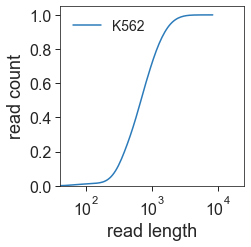

In [13]:
# Plot distribution of sequenced read length
fig, ax = plt.subplots(figsize=(3.3,3.3))

K562_length = np.log10(K562_read_length_df['length'].values)

ax = sns.distplot(K562_length, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[4], bins=100, label='K562')

x_labels = ["$\mathregular{10^{2}}$","$\mathregular{10^{3}}$","$\mathregular{10^{4}}$"]
plt.xticks([2,3,4], x_labels, fontsize=16)
plt.yticks(fontsize=16)

ax.tick_params(axis='both', direction='out', length=5, width=1)
ax.set_ylabel("read count", fontsize=18)
ax.set_xlabel("read length", fontsize=18)
ax.legend(loc=0, fontsize=14, frameon=False)

plt.xlim(1.6,4.4)

plt.savefig('/path/to/K562_CDF_sequenced_read_length.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [16]:
# nano-COP alignment statistics

# read in BAM file
K562_iBAM=pysam.Samfile("/path/to/K562_hg38_minimap2_uniq_sort.bam", 'rb')

# get alignment stats from bam file
K562_alignment_stats_df = get_alignment_stats(K562_iBAM)


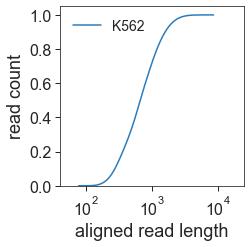

In [19]:
# Plot distribution of aligned read length
fig, ax = plt.subplots(figsize=(3.3,3.3))

K562_alength = np.log10(K562_alignment_stats_df['aligned_length'].values)

ax = sns.distplot(K562_alength, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[4], bins=100, label='K562')

x_labels = ["$\mathregular{10^{2}}$","$\mathregular{10^{3}}$","$\mathregular{10^{4}}$"]
plt.xticks([2,3,4], x_labels, fontsize=16)
plt.yticks(fontsize=16)

ax.tick_params(axis='both', direction='out', length=5, width=1)
ax.set_ylabel("read count", fontsize=18)
ax.set_xlabel("aligned read length", fontsize=18)
ax.legend(loc=0, fontsize=14, frameon=False)

plt.xlim(1.6,4.4)

plt.savefig('/path/to/K562_CDF_aligned_read_length.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

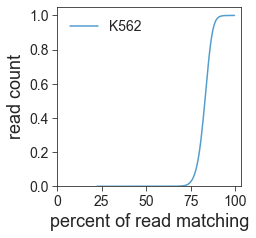

In [22]:
# Plot distribution of match percent
# match percent = (MD tag / Cigar M)
# this is the 1 - (base mismatches / total bases that align to the genome)

fig, ax = plt.subplots(figsize=(3.3,3.3))

K562_match = K562_alignment_stats_df[K562_alignment_stats_df['match_percent']>0]['match_percent'].values

ax = sns.distplot(K562_match, hist=False, kde_kws=dict(cumulative=True), color = sns.color_palette("Blues")[3], bins=100, label='K562')

x_labels = ["0","25","50","75","100"]
plt.xticks([0,25,50,75,100], x_labels, fontsize=16)
plt.yticks(fontsize=16)

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
ax.set_ylabel("read count", fontsize=18)
ax.set_xlabel("percent of read matching", fontsize=18)
ax.legend(fontsize=14, frameon=False)

plt.savefig('/path/to/K562_CDF_match_percent.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

## Mapping RNA 3' ends to gene features

In [10]:
### FUNCTIONS USED TO OBTAIN 3' END MAPPING
def get_all_features_bedtool(annotation_df, polyA_window, post_polyA_window, ss_window_upstream, ss_window_downstream, RNAPET_df, RNAPET_window):

    # make a set for all 3'SS coordinates
    features = []

    # loop through a file with intron coordinates
    # check if feature is an exon
    for i in range(0,len(annotation_df)):
        feature = annotation_df['feature'].iloc[i].split("_")[0]    # feature
 
        if (feature == 'gene'):
            chrom = 'chr'+annotation_df['chrom'].iloc[i]            # chromosome
            start = int(annotation_df['start'].iloc[i])             # start coordinate of intron (last base of exon)
            end = int(annotation_df['end'].iloc[i])                 # end coordinate of intron (last base of intron)
            gene = annotation_df['gene'].iloc[i]                    # gene name
            strand = annotation_df['strand'].iloc[i]                # strand of gene with intron
            name = annotation_df['feature'].iloc[i]                 # get feature and count for output file
   
            if (strand=='+'):
                polyA_start = end - polyA_window
                polyA_end = end + polyA_window
                post_polyA_start = end + polyA_window
                post_polyA_end = end + polyA_window + post_polyA_window
                
            if (strand=='-'):
                polyA_start = start - polyA_window
                polyA_end = start + polyA_window
                post_polyA_start = start - polyA_window - post_polyA_window
                post_polyA_end = start - polyA_window

            features.append([chrom,str(polyA_start),str(polyA_end),gene,'polyA',strand])
            features.append([chrom,str(post_polyA_start),str(post_polyA_end),gene,'post_polyA',strand])
            
        if (feature == 'exon'):
            chrom = 'chr'+annotation_df['chrom'].iloc[i]            # chromosome
            start = int(annotation_df['start'].iloc[i])             # start coordinate of intron (last base of exon)
            end = int(annotation_df['end'].iloc[i])                 # end coordinate of intron (last base of intron)
            gene = annotation_df['gene'].iloc[i]                    # gene name
            strand = annotation_df['strand'].iloc[i]                # strand of gene with intron
            name = annotation_df['feature'].iloc[i]                 # get feature and count for output file
   
            if (end-start > 10):        
                features.append([chrom,str(start),str(end),gene,name,strand])
     
        if (feature == 'intron'):
            chrom = 'chr'+annotation_df['chrom'].iloc[i]            # chromosome
            start = int(annotation_df['start'].iloc[i])             # start coordinate of intron (last base of exon)
            end = int(annotation_df['end'].iloc[i])                 # end coordinate of intron (last base of intron)
            gene = annotation_df['gene'].iloc[i]                    # gene name
            strand = annotation_df['strand'].iloc[i]                # strand of gene with intron
            name = annotation_df['feature'].iloc[i]                 # get feature and count for output file
   
            if (end-start > 10):
                features.append([chrom,str(start),str(end),gene,name,strand])
    
                # get 5' splice site positions for introns on each strand
                if (strand=='+'):
                    ss5_start = int(start)-ss_window_upstream
                    ss5_end = int(start)+ss_window_downstream
                if (strand=='-'):
                    ss5_start = int(end)-ss_window_downstream
                    ss5_end = int(end)+ss_window_upstream

                if (ss5_start > 0 and ss5_end > ss5_start):
                    features.append([chrom,str(ss5_start),str(ss5_end),gene,name+"_SS",strand])


    for i in range(0,len(RNAPET_df)):

        # get features of line in RNA-PET bed file
        chrom = RNAPET_df.iloc[i]['chrom']
        start = RNAPET_df.iloc[i]['start']
        end = RNAPET_df.iloc[i]['end']
        ID = RNAPET_df.iloc[i]['ID']
        score = RNAPET_df.iloc[i]['score'].astype(str)
        strand = RNAPET_df.iloc[i]['strand']
        size = RNAPET_df.iloc[i]['size'].split(',')
        loc = RNAPET_df.iloc[i]['loc'].split(',')

        # process file based on read strand
        # make a new bed file with only information about the polyA site

        if (strand == "+"):
            polyA_start = end - int(size[1]) + 1 - RNAPET_window
            polyA_end = end + RNAPET_window

        if (strand == "-"): 
            polyA_start = start + 1 - RNAPET_window
            polyA_end = start + int(size[0]) + RNAPET_window

        if (polyA_start > 0):
            features.append([chrom,str(polyA_start),str(polyA_end),ID,'RNAPET',strand])

    features_bedtool = BedTool(features)
    return features_bedtool


def get_read_end_bedtool(bamFile):

    bedFile = bamFile.bam_to_bed()
    bedFile_df = bedFile.to_dataframe()
        
    read_end = []
        
    for i in range(0,len(bedFile_df)):

        chrom = 'chr'+str(bedFile_df['chrom'].iloc[i])
        start = bedFile_df['start'].iloc[i]
        end = bedFile_df['end'].iloc[i]
        read = bedFile_df['name'].iloc[i]
        score = bedFile_df['score'].iloc[i]
        strand = bedFile_df['strand'].iloc[i]

        if (strand == "-"):
            pos_1 = start
            pos_2 = start + 1

        if (strand == "+"):
            pos_1 = end - 1
            pos_2 = end

        read_end.append([chrom,str(pos_1),str(pos_2),read,str(score),strand])

    read_end_bedtool = BedTool(read_end)
    return read_end_bedtool




def get_intersect(read_ends, intron_info):

    intersect = read_ends.intersect(intron_info, wo=True, s=True) # intersect reads from bam file with 3' splice site coordinates, ensure strandedness
    intersect_df = intersect.to_dataframe(names=['chrom_read', 'start_read', 'end_read', 'name_read', 'qual_read', \
                                           'strand_read', 'chr_feature', 'start_feature', \
                                           'end_feature', 'name_gene', 'name_feature', 'strand_feature', 'count'], \
                               dtype={"chrom_read": str, "start_read": int, "end_read": int, \
                                     "name_read": str, "qual_read": int, "strand_read": str, \
                                    "chr_feature": str, "start_feature": int, "end_feature": int, "name_gene": str, \
                                     "name_feature": str,"strand_feature": str, "count": int}) # convert to a dataframe

    return intersect_df



def get_read_end_mapping(intersect_df):

    read_ends = {}

    for i in range(0,len(intersect_df)):

        # get read name and feature type
        read = intersect_df['name_read'].iloc[i]
        feature = intersect_df['name_feature'].iloc[i]

        # if 'polyA' is present in the feature (either alone or with 'post')
        # report the feature as is
        if ('polyA' in feature):
            feature_type = feature

        # if 'RNAPET' is present in the feature, report the feature as is
        elif ('RNAPET' in feature):
            feature_type = feature

        # if length of splitting feature name by '_' is 2, it means that 
        # the feature is either an exon or intron and program will report it
        elif (len(feature.split('_')) == 2):
            feature_type = feature.split('_')[0]
            feature_count = feature.split('_')[1]

        # if length of splitting feature name by '_' is 3, it means that 
        # the feature is a splice site and program will report it
        elif (len(feature.split('_')) == 3):
            feature_type = 'intron_'+feature.split('_')[2]
            feature_count = feature.split('_')[1]

        # if length of splitting feature name by '_' is not 2 or 3, it means that 
        # there was an error somewhere in the pipeline
        elif (len(feature.split('_')) != 2 or len(feature.split('_')) != 3):
            print("ERROR with read: "+str(read))

        # check if read name is in the dictionary, if not save it
        if read not in read_ends.keys():

            # make a new dictionary for the read and end mapping info
            read_ends[read] = [feature_type]

        # check if read name is in the dictionary, if not save it
        if read in read_ends.keys():

            # if end mapping info is different, append it to the dictionary
            if (feature_type not in read_ends[read]):
                read_ends[read].append(feature_type)
    
    return read_ends


def get_read_end_stats(read_ends):
    
    read_features = []

    for k, v in read_ends.items():

        if (len(v) == 1):
            read_features.append([k,v[0]])

        if (len(v) > 1):
            if ("polyA" in v):
                read_features.append([k,"polyA"])

            elif ("post_polyA" in v):
                read_features.append([k,"post_polyA"])

            elif ("intron_SS" in v):
                read_features.append([k,"splice_site"])

            elif ("RNAPET" in v):
                read_features.append([k,"RNAPET"])

            else:
                read_features.append([k,"undetermined"])

    read_features_df = pd.DataFrame(read_features)
    read_features_df.columns = ['read','end_feature']
    
    return read_features_df

def get_pie_chart_df(read_features_df,read_ends_bedtool):

    pie_chart = []
    pie_chart.append(['exon',len(read_features_df[read_features_df['end_feature']=='exon'])])
    pie_chart.append(['splice_site',len(read_features_df[read_features_df['end_feature']=='splice_site'])])
    pie_chart.append(['intron',len(read_features_df[read_features_df['end_feature']=='intron'])])
    pie_chart.append(['polyA',len(read_features_df[read_features_df['end_feature']=='polyA'])+len(read_features_df[read_features_df['end_feature']=='RNAPET'])])
    pie_chart.append(['post_polyA',len(read_features_df[read_features_df['end_feature']=='post_polyA'])])
    pie_chart.append(['other',len(read_ends_bedtool.to_dataframe())-len(read_features_df)])
    pie_chart.append(['undetermined',len(read_features_df[read_features_df['end_feature']=='undetermined'])])
    pie_chart_df = pd.DataFrame(pie_chart)
    pie_chart_df = pie_chart_df.set_index([0])
    pie_chart_df.columns = ['count']
    pie_chart_df
    
    return pie_chart_df

In [3]:
# set variables for analysis

polyA_window = 50           # set window for polyA measurement from gtf file
post_polyA_window = 500     # set window for polyA measurement from gtf file
ss_window_upstream = 50     # set window for splice sites measurement from gtf file (upstream of 5'SS)
ss_window_downstream = 10   # set window for splice sites measurement from gtf file (downstream of 5'SS)
RNAPET_window = 50          # set window for transcript ends from RNA-PET data

In [4]:
# upload hg38 annotation files for analysis
hg38_df = pd.read_table('/path/to/annotation_files/NCBI_RefSeq_hg38_merge_parsed_sortByNameCoord.bed',header=None)
hg38_df.columns = ['chrom','start', 'end','gene','feature','strand']

# import RNAPET bed files with gene starts and ends
K562_RNAPET_cyt = pd.read_table('/path/to/annotation_files/K562_ENCODE_RNAPET_cytosol_hg38_CrossMap.bed',header=None)
K562_RNAPET_cyt.columns = ['chrom','start','end','ID','score','strand','start2','end2','zero','number','size','loc']
K562_RNAPET_chr = pd.read_table('/path/to/annotation_files/K562_ENCODE_RNAPET_chromatin_hg38_CrossMap.bed',header=None)
K562_RNAPET_chr.columns = ['chrom','start','end','ID','score','strand','start2','end2','zero','number','size','loc']

# merge cytoplasm and chromatin RNAPET bed files
K562_RNAPET_all = pd.concat([K562_RNAPET_cyt,K562_RNAPET_chr])

In [5]:
# make a bedtool with all feature coordinates
hg38_all_features = get_all_features_bedtool(hg38_df, polyA_window, post_polyA_window, ss_window_upstream, ss_window_downstream, K562_RNAPET_all, RNAPET_window)

In [9]:
# upload K562 alignment file for analysis
K562_bamFile = pybedtools.BedTool('/path/to/K562_hg38_minimap2_uniq_sort.bam')

# get read ends and turn into a bedtool for intersecting 
K562_read_ends = get_read_end_bedtool(K562_bamFile)

# intersect read ends with genome features
K562_intersect = get_intersect(K562_read_ends, hg38_all_features)

# get read ends dictionary
K562_read_end_mapping = get_read_end_mapping(K562_intersect)

# get read end mapping statistics
K562_read_end_stats = get_read_end_stats(K562_read_end_mapping)


/Users/karinechoquet/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


/Users/karinechoquet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # Remove the CWD from sys.path while we load stuff.


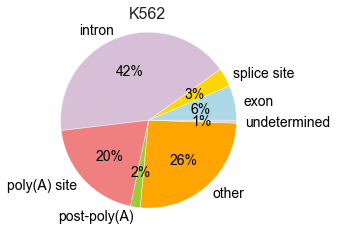

In [14]:
# make dataframe for pie chart
K562_pie_chart_df = get_pie_chart_df(K562_read_end_stats, K562_read_ends)

# plot pie chart
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(3.5,3.5))

col_list = ['lightblue', 'gold', 'thistle', 'lightcoral', 'yellowgreen', 'orange', 'lightgray']
label_list=['exon','splice site','intron','poly(A) site','post-poly(A)','other','undetermined']

wedges, texts, autotexts = ax.pie(K562_pie_chart_df, labels=label_list, colors=col_list, autopct='%1.0f%%')
ax.axis('equal')    # Equal aspect ratio ensures that pie is drawn as a circle
ax.set_title('K562', fontsize=16)

for text in texts:
    text.set_color('black')
    text.set_fontsize(14)

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(14)

for w in wedges:
    w.set_linewidth(0.5)
    w.set_edgecolor('whitesmoke')

plt.savefig('/path/to/K562_3primeEnd_pie_chart.pdf', format='pdf', dpi=300, bbox_inches='tight')
    
#plt.tight_layout()
plt.show()

## Physical distance between transcription and splicing

In [35]:
### FUNCTIONS USED TO MEASURE AND PLOT THE DISTANCE TRANSCRIBED BEFORE SPLICING
def get_discarded_features_wiRNAPET_bedtool(annotation_df, polyA_window, ss_window_upstream, ss_window_downstream, RNAPET_df, RNAPET_window):

    # make a set for all 3'SS coordinates
    features = []

    # loop through a file with intron coordinates
    for i in range(0,len(annotation_df)):
        feature = annotation_df['feature'].iloc[i].split("_")[0]    # feature
 
        # check if feature is a gene and record region around polyA site
        if (feature == 'gene'):
            #chrom = 'chr'+str(annotation_df['chrom'].iloc[i])       # chromosome
            chrom = str(annotation_df['chrom'].iloc[i])
            start = int(annotation_df['start'].iloc[i])             # start coordinate of intron (last base of exon)
            end = int(annotation_df['end'].iloc[i])                 # end coordinate of intron (last base of intron)
            gene = annotation_df['gene'].iloc[i]                    # gene name
            strand = annotation_df['strand'].iloc[i]                # strand of gene with intron
            name = annotation_df['feature'].iloc[i]                 # get feature and count for output file
   
            if (strand=='+'):
                polyA_start = end - polyA_window
                polyA_end = end + polyA_window
                
            if (strand=='-'):
                polyA_start = start - polyA_window
                polyA_end = start + polyA_window

            if (polyA_window > 0):
                features.append([chrom,polyA_start,polyA_end,gene,'polyA',strand])
            
        # check if feature is an intron and record region around 5'SS site   
        if (feature == 'intron'):
            #chrom = 'chr'+str(annotation_df['chrom'].iloc[i])       # chromosome
            chrom = str(annotation_df['chrom'].iloc[i])
            start = int(annotation_df['start'].iloc[i])             # start coordinate of intron (last base of exon)
            end = int(annotation_df['end'].iloc[i])                 # end coordinate of intron (last base of intron)
            gene = annotation_df['gene'].iloc[i]                    # gene name
            strand = annotation_df['strand'].iloc[i]                # strand of gene with intron
            name = annotation_df['feature'].iloc[i]                 # get feature and count for output file
   
            # get 5' splice site positions for introns on each strand
            if (strand=='+'):
                ss5_start = int(start)-ss_window_upstream
                ss5_end = int(start)+ss_window_downstream
            if (strand=='-'):
                ss5_start = int(end)-ss_window_downstream
                ss5_end = int(end)+ss_window_upstream

            if (ss5_start > 0 and ss5_end > ss5_start):
                features.append([chrom,ss5_start,ss5_end,gene,name+"_SS",strand])

    # record regions around 3' end RNA-PET coordinates from ENCODE data
    for i in range(0,len(RNAPET_df)):

        # get features of line in RNA-PET bed file
        chrom = str(RNAPET_df.iloc[i]['chrom'])
        start = int(RNAPET_df.iloc[i]['start'])
        end = int(RNAPET_df.iloc[i]['end'])
        ID = RNAPET_df.iloc[i]['ID']
        score = RNAPET_df.iloc[i]['score'].astype(str)
        strand = RNAPET_df.iloc[i]['strand']
        size = RNAPET_df.iloc[i]['size'].split(',')
        loc = RNAPET_df.iloc[i]['loc'].split(',')

        # process file based on read strand
        # make a new bed file with only information about the polyA site

        if (strand == "+"):
            polyA_start = end - int(size[1]) + 1 - RNAPET_window
            polyA_end = end + RNAPET_window

        if (strand == "-"): 
            polyA_start = start + 1 - RNAPET_window
            polyA_end = start + int(size[0]) + RNAPET_window

        if (polyA_start > 0):
            features.append([chrom[3:],polyA_start,polyA_end,ID,'polyA',strand])

    features_bedtool = BedTool(features)
    return features_bedtool


# make a bed tool with coordinates of read 3' ends
def get_read_end_bedtool(bamFile):

    bedFile = bamFile.bam_to_bed()
    bedFile_df = bedFile.to_dataframe(names=['chrom', 'start', 'end', 'name', 'score', 'strand'] , \
                               dtype={"chrom": str, "start": int, "end": int, "name": str, \
                                      "score": bytes, "strand": str}) # convert to a dataframe       
    
    read_end = []
        
    for i in range(0,len(bedFile_df)):
        chrom = str(bedFile_df['chrom'].iloc[i])
        start = int(bedFile_df['start'].iloc[i])
        end = int(bedFile_df['end'].iloc[i])
        read = bedFile_df['name'].iloc[i]
        score = bedFile_df['score'].iloc[i]
        strand = bedFile_df['strand'].iloc[i]

        if (strand == "-"):
            pos_1 = start
            pos_2 = start + 1

        if (strand == "+"):
            pos_1 = end - 1
            pos_2 = end

        read_end.append([chrom,pos_1,pos_2,read,score,strand])

    read_end_bedtool = BedTool(read_end)
    return read_end_bedtool


# intersect 3' ends with discarded features bed file 
# to get reads that will be removed from the analysis
def get_discarded_reads(bamFile, features):

    # get read ends and turn into a bedtool for intersecting 
    read_ends_bedtool = get_read_end_bedtool(bamFile)

    # intersect read ends with genome features
    intersect = read_ends_bedtool.intersect(features, wo=True, s=True) # intersect reads from bam file with 3' splice site coordinates, ensure strandedness
    intersect_df = intersect.to_dataframe(names=['chrom_read', 'start_read', 'end_read', 'name_read', 'qual_read', \
                                           'strand_read', 'chr_feature', 'start_feature', \
                                           'end_feature', 'name_gene', 'name_feature', 'strand_feature', 'count'], \
                               dtype={"chrom_read": str, "start_read": int, "end_read": int, \
                                     "name_read": str, "qual_read": int, "strand_read": str, \
                                    "chr_feature": str, "start_feature": int, "end_feature": int, "name_gene": str, \
                                     "name_feature": str,"strand_feature": str, "count": int}) # convert to a dataframe

    unique_read_names = set(intersect_df['name_read'])

    return unique_read_names



# make a bed tool with intron coordinates
def get_introns_bedtool(annotation_df, window):

    # make a set for all 3'SS coordinates
    introns = []

    # loop through a file with intron coordinates
    # check if feature is an exon
    for i in range(0,len(annotation_df)):
        feature = annotation_df['feature'].iloc[i].split("_")[0]    # feature
 
        if (feature == 'intron'):
            chrom = annotation_df['chrom'].iloc[i]                  # chromosome
            start = int(annotation_df['start'].iloc[i])             # start coordinate of intron (last base of exon)
            end = int(annotation_df['end'].iloc[i])                 # end coordinate of intron (last base of intron)
            gene = annotation_df['gene'].iloc[i]                    # gene name
            strand = annotation_df['strand'].iloc[i]                # strand of gene with intron
            name = annotation_df['feature'].iloc[i]                 # get feature and count for output file
   
            if (end-start > 2*window):
                start = start + window
                end = end - window 

            introns.append([chrom,start,end,gene,name,strand])
    
    introns_bedtool = BedTool(introns)
    return introns_bedtool


# function to get a bedtool file with splice site info from hg38 intron coordinate bed file
def human_spliceSites(intronFile):
    # make a set for all 3'SS coordinates
    introns = []

    # loop through a file with intron coordinates
    # record features about the introns
    for line in intronFile:
        chrom = str(line.split('\t')[0])      # chromosome
        start = line.split('\t')[1]                 # start coordinate of intron (last base of exon)
        end = line.split('\t')[2]                   # end coordinate of intron (last base of intron)
        name = line.split('\t')[3]                  # gene name and polyA site for that gene (multiples are split with "_")
        strand = line.split('\t')[4][0]             # strand of gene with intron

        # get 3' SS positions for introns plus one base
        if strand=='+':
            pos1 = int(end)
            pos2 = int(end)+1
            pos5prime = int(start)+1
        if strand=='-':
            pos1 = int(start)
            pos2 = int(start)+1
            pos5prime = int(end)

        # make a key that will represent intron coordinates
        introns.append([str(chrom),str(pos1),str(pos2),str(name),str(pos5prime),str(strand)])

    spliceSites = BedTool(introns)
    intronFile.close()
    return spliceSites



# function to create a dataframe with reads that span 3'SS positions
def get_spliceSite_df(spliceSites, bamFile):
    # get reads that span 3' splice sites and convert to a dataframe
    bedFile = bamFile.bam_to_bed(cigar=True, tag='NM') # convert bam file to bed file, keep cigar string and NM (edit distance) tag
    intersect = bedFile.intersect(spliceSites, wo=True, s=True) # intersect reads from bam file with 3' splice site coordinates, ensure strandedness
    df = intersect.to_dataframe(names=['chrom', 'start_aln', 'end_aln', 'name_aln', 'qual_aln', \
                                           'strand_aln', 'cigar_aln', 'chr_3SS', 'start_3SS', \
                                           'end_3SS', 'name_gene_polyA', 'pos_5SS', 'strand_gene', 'count'], \
                               dtype={"chrom": str, "start_aln": int, "end_aln": int, \
                                     "name_aln": str, "qual_aln": int, "strand_aln": str, \
                                     "cigar_aln": str, "chr_3SS": str, "start_3SS": int, \
                                     "end_3SS": int, "name_gene_polyA": str, \
                                     "pos_5SS": int,"strand_gene": str, "count": int}) # convert to a dataframe
    return df


def get_MinION_spliceCalls(df, min_overlap):
    
    # prepare a list for splice calls
    spliceCalls = []

    # set variables for parsing the cigar string
    pattern = re.compile('([MIDNSHPX=])')
    Consumes_Query = ["M", "I", "S", "=", "X"]
    Consumes_Reference = ["M", "D", "N", "=", "X"]    

    # loop through all reads that span splice sites
    for i in range(0,df.shape[0]):
        if df.strand_gene[i] == "-":
            align_3p_end = df.start_aln[i] # record 3' end of read for - strand genes
            align_5p_end = df.end_aln[i] # record 5' end of read for - strand genes
            pos_3SS = df.end_3SS[i] # record 3'SS position for - strand genes
            pos_5SS = df.pos_5SS[i] # record 5'SS position for - strand genes
            intron_start = pos_3SS # get position for the start of intron coordinate on negative strand
            intron_end = pos_5SS # get position for the end of intron coordinate on negative strand

        if df.strand_gene[i] == "+":
            align_3p_end = df.end_aln[i] # record 3' end of read for + strand genes
            align_5p_end = df.start_aln[i] # record 5' end of read for + strand genes
            pos_3SS = df.start_3SS[i] # record 3'SS position for + strand genes 
            pos_5SS = df.pos_5SS[i] # record 5'SS position for - strand genes 
            intron_start = pos_5SS # get position for the start of intron coordinate on positive strand
            intron_end = pos_3SS # get position for the end of intron coordinate on positive strand
            
        # calculate distance between 3'SS and 3'end of read 
        dist = abs(align_3p_end - pos_3SS) #*** double check this!!!

        # parse cigar string into a list of tuples for easy parsing
        Sep_Values = pattern.split(df.cigar_aln[i])[:-1]
        CigarPairs = list((Sep_Values[n:n+2] for n in range(0, len(Sep_Values), 2)))  

        # get the 3' softclip length
        if df.strand_aln[i]=="+":        
            last=len(CigarPairs)
            if(CigarPairs[last-1][1]=='S'):
                clip=CigarPairs[last-1][0]
            elif(CigarPairs[last-1][1]=='H'):
                clip=CigarPairs[last-1][0]
            elif(CigarPairs[last-1][1]!='S' or CigarPairs[last-1][1]!='H'):
                clip=0

        if df.strand_aln[i]=="-":
            if(CigarPairs[0][1]=='S'):
                clip=CigarPairs[0][0]
            elif(CigarPairs[0][1]=='H'):
                clip=CigarPairs[0][0]
            elif(CigarPairs[0][1]!='S' or CigarPairs[0][1]!='H'):
                clip=0

        # set up variables for measuring the length of cigar string operators
        CigarOp_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        start_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        end_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        intron_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        currentloc = int(df.start_aln[i]) 

        # go through list of cigar strings and grab splicing information
        for cigar_Entry in CigarPairs:

            op_Length = int(cigar_Entry[0]) # get length of cigar operator
            cigarOp = cigar_Entry[1] # get type of cigar operator  
            CigarOp_counts[cigarOp] += op_Length # add the cigar operator length to the counts dictionary
            cigarOp_start=currentloc # get the starting coordinate of the cigar operator

            if (cigarOp in Consumes_Reference):
                currentloc=currentloc+op_Length # add the cigar operator length to the current location coordinate 

            cigarOp_end=currentloc # get the ending coordinate of the cigar operator

            # gather information if the portion of the cigar string spans the designated 5' splice site
            if (cigarOp_start<intron_start-min_overlap and cigarOp_end>=intron_start-min_overlap):
                if (cigarOp_end>=intron_start+min_overlap):
                    count=min_overlap*2
                else:
                    count=cigarOp_end-(intron_start-min_overlap)+1
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_start-min_overlap and cigarOp_end<intron_start+min_overlap):
                count=op_Length
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary       

            elif (cigarOp_start<intron_start+min_overlap and cigarOp_end>=intron_start+min_overlap):
                if (cigarOp_start<=intron_start-min_overlap):
                    count=min_overlap*2
                else:
                    count=(intron_start+min_overlap)-cigarOp_start-1
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

            # gather information if the portion of the cigar string is within the intron
            if (cigarOp_start<intron_start and cigarOp_end>=intron_start):
                if (cigarOp_end>=intron_end):
                    count=intron_end-intron_start
                else:
                    count=cigarOp_end-intron_start
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_start and cigarOp_end<intron_end):
                count=op_Length
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start<intron_end and cigarOp_end>=intron_end):
                if (cigarOp_start<=intron_start):
                    count=intron_end-intron_start
                else:
                    count=intron_end-cigarOp_start
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

            # gather information if the portion of the cigar string spans the designated 3' splice site
            if (cigarOp_start<intron_end-min_overlap and cigarOp_end>=intron_end-min_overlap):
                if (cigarOp_end>=intron_end+min_overlap):
                    count=min_overlap*2
                else:
                    count=cigarOp_end-(intron_end-min_overlap)
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_end-min_overlap and cigarOp_end<intron_end+min_overlap):
                count=op_Length
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start<intron_end+min_overlap and cigarOp_end>=intron_end+min_overlap):
                if (cigarOp_start<=intron_end-min_overlap):
                    count=min_overlap*2
                else:
                    count=(intron_end+min_overlap)-cigarOp_start
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

        # assign strandedness to determine counts around 5'SS and 3'SS
        if(df.strand_gene[i]=='+'):
            around5SS_counts = start_counts
            around3SS_counts = end_counts

        elif(df.strand_gene[i]=="-"):
            around5SS_counts = end_counts
            around3SS_counts = start_counts

        # annotate splicing status based on CIGAR string information around splice sites
        if(around3SS_counts['N']==0 and around3SS_counts['M']>min_overlap/2):
            splice='NO'
        elif(around3SS_counts['N']>0 and around3SS_counts['N']<min_overlap*2):
            if(around5SS_counts['N']>0 and around5SS_counts['N']<min_overlap*2):
                splice='YES'
            else:
                splice='UNDETERMINED'
        else:
            splice='UNDETERMINED'

        # annotate splicing status based on CIGAR string information within the intron 
        if (splice == 'YES'):
            if (float(intron_end-intron_start) > 0.0):
                ratio = float(intron_counts['N'])/float(intron_end-intron_start)
                difference = abs(intron_counts['N']-(intron_end-intron_start))
                # if read is spliced, between 90-100% of the intron has to be spliced 
                # and no more than 100 nucleotides within the intron can be matching the intron sequence
                if( ratio < 0.9 or ratio > 1.1 or difference > 100):
                    splice='UNDETERMINED'
            if (float(intron_end-intron_start) == 0.0):
                splice='UNDETERMINED'

        if (splice == 'NO'):
            if (float(intron_end-intron_start) > 0.0):
                intronLength = intron_end-intron_start
                difference = abs(intron_counts['M']+intron_counts['D']+intron_counts['S']-intronLength)
                ratio = float(intron_counts['M'])/(float(intron_counts['M'])+float(intron_counts['N'])+float(intron_counts['D'])+1)
                # if read is unspliced, at least 70% of the read has to match (CIGAR=M) the intron sequence
                # and at least 10 nucleotides must match (CIGAR=M) within the intron sequence
                if(intron_counts['M'] < 10 or ratio < 0.7):
                    splice='UNDETERMINED'
            if (float(intron_end-intron_start) == 0.0):
                splice='UNDETERMINED'
        
        
        # get information on match percentage / error length 
        # this will be used as a quality control cutoff if necessary
        read_length = CigarOp_counts['M']+CigarOp_counts['I']
        error_rate = float(df.qual_aln[i])/float(read_length)

        spliceCalls.append([df.name_aln[i],df.chrom[i],str(intron_start),str(intron_end),str(align_5p_end),str(align_3p_end),str(read_length),df.strand_gene[i],str(error_rate),str(clip),str(dist),splice,df.name_gene_polyA[i]])
    
    spliceCalls_df = pd.DataFrame(spliceCalls)
    spliceCalls_df.columns = ["read_name","chrom","intron_start","intron_end","read_start","read_end","read_length","strand","error_rate","end_clippling","dist_from_3SS","splice_status","gene_name_polyA"]
   
    return spliceCalls_df


def get_MinION_spliceCalls_noPolyA(gene_name_polyA, strand, read_end, polyA_dist):

    # delimeter to identify if read has a 3' end near a polyA site
    near_polyA = 'NO'

    # count the number of polyA sites associated with a gene
    polyA_count = int(len(gene_name_polyA.split('_'))/3)

    # loop through all polyA sites associated with the aligned gene
    for j in range(0,polyA_count):
        tag = gene_name_polyA.split('_')[j*3+0]
        gene = gene_name_polyA.split('_')[j*3+1]
        polyA = int(gene_name_polyA.split('_')[j*3+2])

        if (strand=='+' and int(read_end)>(polyA-polyA_dist)):
            near_polyA = 'YES'
        elif (strand=='-' and int(read_end)<(polyA+polyA_dist)):
            near_polyA = 'YES'   
    
    return near_polyA


def get_processed_splice_calls(df, read_overhang, max_softclip):
    
    df['near_polyA'] = df.apply(lambda row: get_MinION_spliceCalls_noPolyA(row.gene_name_polyA,row.strand,row.read_end,polyA_dist), axis=1)
    df_nopolyA = df[df['near_polyA']=='NO'].reset_index(drop=True)   
    df_capable = df_nopolyA[(df_nopolyA['read_length'].astype(int)-read_overhang)>df_nopolyA['dist_from_3SS'].astype(int)].reset_index(drop=True)
    df_softclip = df_capable[df_capable['end_clippling'].astype(int)<max_softclip].reset_index(drop=True)   
    
    return df_softclip


# function to create a dataframe with reads that span 3'SS positions
def get_spliceSite_df(spliceSites, bamFile):
    # get reads that span 3' splice sites and convert to a dataframe
    bedFile = bamFile.bam_to_bed(cigar=True, tag='NM') # convert bam file to bed file, keep cigar string and NM (edit distance) tag
    intersect = bedFile.intersect(spliceSites, wo=True, s=True) # intersect reads from bam file with 3' splice site coordinates, ensure strandedness
    df = intersect.to_dataframe(names=['chrom', 'start_aln', 'end_aln', 'name_aln', 'qual_aln', \
                                           'strand_aln', 'cigar_aln', 'chr_3SS', 'start_3SS', \
                                           'end_3SS', 'name_gene_polyA', 'pos_5SS', 'strand_gene', 'count'], \
                               dtype={"chrom": str, "start_aln": int, "end_aln": int, \
                                     "name_aln": str, "qual_aln": int, "strand_aln": str, \
                                     "cigar_aln": str, "chr_3SS": str, "start_3SS": int, \
                                     "end_3SS": int, "name_gene_polyA": str, \
                                     "pos_5SS": int,"strand_gene": str, "count": int}) # convert to a dataframe
    return df


def get_discarded_splice_df(bamFile, discarded_reads, spliceSites, min_overlap, read_overhang, max_softclip):
    
    # get reads that span 3' splice sites and convert to a dataframe
    bedFile = bamFile.bam_to_bed(cigar=True, tag='NM') # convert bam file to bed file, keep cigar string and NM (edit distance) tag
    filtered_reads_bedtool = bedFile.filter(lambda b: b.name not in discarded_reads)
    filtered_reads_bedtool = filtered_reads_bedtool.saveas()

    intersect = filtered_reads_bedtool.intersect(spliceSites, wo=True, s=True) # intersect reads from bam file with 3' splice site coordinates, ensure strandedness
    splicingReads = intersect.to_dataframe(names=['chrom', 'start_aln', 'end_aln', 'name_aln', 'qual_aln', \
                                           'strand_aln', 'cigar_aln', 'chr_3SS', 'start_3SS', \
                                           'end_3SS', 'name_gene_polyA', 'pos_5SS', 'strand_gene', 'count'], \
                               dtype={"chrom": str, "start_aln": int, "end_aln": int, \
                                     "name_aln": str, "qual_aln": int, "strand_aln": str, \
                                     "cigar_aln": str, "chr_3SS": str, "start_3SS": int, \
                                     "end_3SS": int, "name_gene_polyA": str, \
                                     "pos_5SS": int,"strand_gene": str, "count": int}) # convert to a dataframe
    
    splicingCalls = get_MinION_spliceCalls(splicingReads, min_overlap) #determine splicing status and distance
    splice_df = get_processed_splice_calls(splicingCalls, read_overhang, max_softclip) #process files (e.g. not near polyA, splicing capable, and minimal softclip)

    return splice_df

In [17]:
# set all variables for analysis
# set variables for analysis

# discarded reads
polyA_window = 50           # set window for polyA measurement from gtf file
ss_window_upstream = 50      # set window for splice sites measurement from gtf file (upstream of 5'SS)
ss_window_downstream = 10    # set window for splice sites measurement from gtf file (downstream of 5'SS)
RNAPET_window = 50          # set window for transcript ends from RNA-PET data

# splicing dataframe
min_overlap = 25    # overlap required to call splicing

# splicing dataframe
polyA_dist = 150    # distance from polyA site to designate 3' end within gene
read_overhang = 150    # distance that read has to overlap upstream of 3' SS
max_softclip = 150    # maximum softclipping allowed at the start of the read


In [19]:
# upload files for processing (K562 cells)

# upload hg38 annotation files for analysis
hg38_df = pd.read_table('/path/to/annotation_files/NCBI_RefSeq_hg38_merge_parsed_sortByNameCoord.bed',header=None)
hg38_df.columns = ['chrom','start', 'end','gene','feature','strand']

# import RNAPET bed files with gene starts and ends
K562_RNAPET_cyt = pd.read_table('/path/to/annotation_files/K562_ENCODE_RNAPET_cytosol_hg38_CrossMap.bed',header=None)
K562_RNAPET_cyt.columns = ['chrom','start','end','ID','score','strand','start2','end2','zero','number','size','loc']
K562_RNAPET_chr = pd.read_table('/path/to/annotation_files/K562_ENCODE_RNAPET_chromatin_hg38_CrossMap.bed',header=None)
K562_RNAPET_chr.columns = ['chrom','start','end','ID','score','strand','start2','end2','zero','number','size','loc']

# merge cytoplasm and chromatin RNAPET bed files
K562_RNAPET_all = pd.concat([K562_RNAPET_cyt,K562_RNAPET_chr])

# install splice sites from K562 intron files
# this annotation file is produced using instructions in Box 3 of the nano-COP protocol
K562_medium_intronFile = open('/path/to/annotation_files/K562_intronCoords_mediumStringency.txt')
K562_medium_spliceSites = human_spliceSites(K562_medium_intronFile) # get splice sites

# upload alignment files for processing - K562 cells poly(A)
K562_1_bamFile = pybedtools.BedTool('/path/to/K562_1_hg38_minimap2_uniq_sort.bam')
K562_2_bamFile = pybedtools.BedTool('/path/to/K562_2_hg38_minimap2_uniq_sort.bam')
K562_3_bamFile = pybedtools.BedTool('/path/to/K562_3_hg38_minimap2_uniq_sort.bam')

# upload alignment files for processing - K562 cells poly(I)
K562_4_bamFile = pybedtools.BedTool('/path/to/K562_4_hg38_minimap2_uniq_sort.bam')
K562_5a_bamFile = pybedtools.BedTool('/path/to/K562_5a_hg38_minimap2_uniq_sort.bam')
K562_5b_bamFile = pybedtools.BedTool('/path/to/K562_5b_hg38_minimap2_uniq_sort.bam')


In [37]:
# collect reads that will be discarded from distance spliced analysis (K562 cells)

# create a bed file with all regions that may not be representative of a transcription position
K562_discarded_features = get_discarded_features_wiRNAPET_bedtool(hg38_df, polyA_window, ss_window_upstream, ss_window_downstream, K562_RNAPET_all, RNAPET_window)

# remove reads that have 3' ends within the bed file for discarded regions
K562_1_discarded_reads = get_discarded_reads(K562_1_bamFile,K562_discarded_features)
K562_2_discarded_reads = get_discarded_reads(K562_2_bamFile,K562_discarded_features)
K562_3_discarded_reads = get_discarded_reads(K562_3_bamFile,K562_discarded_features)
K562_4_discarded_reads = get_discarded_reads(K562_4_bamFile,K562_discarded_features)
K562_5a_discarded_reads = get_discarded_reads(K562_5a_bamFile,K562_discarded_features)
K562_5b_discarded_reads = get_discarded_reads(K562_5b_bamFile,K562_discarded_features)


In [38]:
# get splice dataframes for plotting (after discarding unwanted reads) (K562 cells)
K562_1_splice_df = get_discarded_splice_df(K562_1_bamFile, K562_1_discarded_reads, K562_medium_spliceSites, min_overlap, read_overhang, max_softclip)
K562_2_splice_df = get_discarded_splice_df(K562_2_bamFile, K562_2_discarded_reads, K562_medium_spliceSites, min_overlap, read_overhang, max_softclip)
K562_3_splice_df = get_discarded_splice_df(K562_3_bamFile, K562_3_discarded_reads, K562_medium_spliceSites, min_overlap, read_overhang, max_softclip)
K562_4_splice_df = get_discarded_splice_df(K562_4_bamFile, K562_4_discarded_reads, K562_medium_spliceSites, min_overlap, read_overhang, max_softclip)
K562_5a_splice_df = get_discarded_splice_df(K562_5a_bamFile, K562_5a_discarded_reads, K562_medium_spliceSites, min_overlap, read_overhang, max_softclip)
K562_5b_splice_df = get_discarded_splice_df(K562_5b_bamFile, K562_5b_discarded_reads, K562_medium_spliceSites, min_overlap, read_overhang, max_softclip)

# Combine the two technical replicates
K562_5_splice_df = pd.concat([K562_5a_splice_df,K562_5b_splice_df]).reset_index(drop=True)


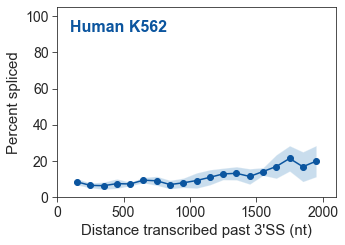

In [42]:
fig, ax = plt.subplots(figsize=(5,3.5))


######### set variables for plot #########
window = 100
plot_min = 100
plot_max = 2000      


######### get info for each sample - Human #########
samples=['K562_1','K562_2','K562_3','K562_4','K562_5']

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        spliced_count = splicedf_spliced
        unspliced_count = splicedf_unspliced
        plot_list.append([plot_range_high,name,spliced_count,unspliced_count,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','spliced_count','unspliced_count','count','percentSpliced']
human_plot_df = plot_df.copy()
human_N = np.sum(plot_df['count'])

######### get statistics for Human #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for Human #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Blues")[5])
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Blues")[4], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Blues")[5])




plt.ylabel("Percent spliced", fontsize=15)
plt.xlabel("Distance transcribed past 3'SS (nt)", fontsize=15)
plt.text(100, 98, 'Human K562', horizontalalignment='left', verticalalignment='top', fontsize=16, weight='bold', color=sns.color_palette("Blues")[5])

plt.xticks([0,500,1000,1500,2000], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.xlim(0,2100)
plt.ylim(0,105)

plt.savefig('/path/to/K562_distance_spliced_plot.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

## Order of splicing in intron pairs

In [55]:
### FUNCTIONS USED TO DETERMINE THE ORDER OF SPLICING IN INTRON PAIRS

# function to get a bedtool file with splice site info from hg38 intron coordinate bed file
def hg38_introns(intronFile):
    # make a set for all intron coordinates
    introns = []

    # loop through a file with intron coordinates
    # record features about the introns
    for line in intronFile:
        chrom = str(line.split('\t')[0])                  # chromosome
        start = line.split('\t')[1]                       # start coordinate of intron (last base of exon)
        end = line.split('\t')[2]                         # end coordinate of intron (last base of intron)
        name_split = line.split('\t')[3].split('_intron') # split name file by intron
        gene = name_split[0]                              # gene name
        feature = name_split[1].split('_')[1]             # intron count
        strand = line.split('\t')[5][0]                   # strand of gene with intron

        # make a key that will represent intron coordinates
        introns.append([str(chrom),str(start),str(end),str(gene),str(feature),str(strand)])

    #introns_df = pd.DataFrame(introns)
    #introns_df.columns = ["chrom","start","end","gene","feature","strand"]
    introns_bedtool = BedTool(introns)
    intronFile.close()
    return introns_bedtool


# function to get a bedtool file with splice site info from hg38 intron coordinate bed file
def dmel_introns(intronFile):
    # make a set for all intron coordinates
    introns = []

    # loop through a file with intron coordinates
    # record features about the introns
    for line in intronFile:
        chrom = 'chr'+str(line.split('\t')[0])                  # chromosome
        start = line.split('\t')[1]                       # start coordinate of intron (last base of exon)
        end = line.split('\t')[2]                         # end coordinate of intron (last base of intron)
        name_split = line.split('\t')[3].split('_intron') # split name file by intron
        gene = name_split[0]                              # gene name
        feature = name_split[1].split('_')[1]             # intron count
        strand = line.split('\t')[5][0]                   # strand of gene with intron

        # make a key that will represent intron coordinates
        introns.append([str(chrom),str(start),str(end),str(gene),str(feature),str(strand)])

    #introns_df = pd.DataFrame(introns)
    #introns_df.columns = ["chrom","start","end","gene","feature","strand"]
    introns_bedtool = BedTool(introns)
    intronFile.close()
    return introns_bedtool


# function to create a dataframe with reads that span 3'SS positions
def get_intron_intersect(introns_df, bam_file):
    # get reads that span 3' splice sites and convert to a dataframe
    bedFile = bam_file.bam_to_bed(cigar=True, tag='NM') # convert bam file to bed file, keep cigar string and NM (edit distance) tag
    intersect = bedFile.intersect(introns_df, wo=True, s=True) # intersect reads from bam file with 3' splice site coordinates, ensure strandedness
    df = intersect.to_dataframe(names=['chr_aln', 'start_aln', 'end_aln', 'name_aln', 'qual_aln', \
                                           'strand_aln', 'cigar_aln', 'chr_intron', 'start_intron', \
                                           'end_intron', 'name_gene', 'intron_count', 'strand_gene', 'count'], \
                               dtype={"chr_aln": str, "start_aln": int, "end_aln": int, \
                                     "name_aln": str, "qual_aln": int, "strand_aln": str, \
                                     "cigar_aln": str, "chr_intron": str, "start_intron": int, \
                                     "end_intron": int, "name_gene": str, \
                                     "intron_count": int,"strand_gene": str, "count": int}) # convert to a dataframe
    return df


# function to create a dataframe with splicing information for
# every read that spans an intron in the dataset
def get_splicing_info(intersect_df, min_overlap):
    
    df = intersect_df

    # prepare a list for splice calls
    spliceCalls = []

    # set variables for parsing the cigar string
    pattern = re.compile('([MIDNSHPX=])')
    Consumes_Query = ["M", "I", "S", "=", "X"]
    Consumes_Reference = ["M", "D", "N", "=", "X"]    

    # loop through all read-intron intersects
    for i in range(0,df.shape[0]):

        # ignore reads that do not overlap intron by minimum threshold
        if (df['count'].iloc[i] < min_overlap):
            continue

        # record the start and ends of reads 
        # will deal with gene strand after cigar counts are made
        aln_start = df['start_aln'].iloc[i] # record the start of the read
        aln_end = df['end_aln'].iloc[i] # record the end of the read
        intron_start = df['start_intron'].iloc[i] # record the end of the intron
        intron_end = df['end_intron'].iloc[i] # record the end of the intron

        # parse cigar string into a list of tuples for easy parsing
        Sep_Values = pattern.split(df['cigar_aln'].iloc[i])[:-1]
        CigarPairs = list((Sep_Values[n:n+2] for n in range(0, len(Sep_Values), 2)))  

        # set up variables for measuring the length of cigar string operators
        CigarOp_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        start_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        end_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        intron_counts = {'M': 0, 'I': 0, 'D': 0, 'N': 0, 'S': 0, 'H': 0, 'P': 0, '=': 0, 'X': 0}
        currentloc = int(df['start_aln'].iloc[i])

        # go through list of cigar strings and grab splicing information
        for cigar_Entry in CigarPairs:

            op_Length = int(cigar_Entry[0]) # get length of cigar operator
            cigarOp = cigar_Entry[1] # get type of cigar operator  
            CigarOp_counts[cigarOp] += op_Length # add the cigar operator length to the counts dictionary
            cigarOp_start=currentloc # get the starting coordinate of the cigar operator

            if (cigarOp in Consumes_Reference):
                currentloc=currentloc+op_Length # add the cigar operator length to the current location coordinate 

            cigarOp_end=currentloc # get the ending coordinate of the cigar operator

            # gather information if the portion of the cigar string spans the designated intron start
            if (cigarOp_start<intron_start-min_overlap and cigarOp_end>=intron_start-min_overlap):
                if (cigarOp_end>=intron_start+min_overlap):
                    count=min_overlap*2
                else:
                    count=cigarOp_end-(intron_start-min_overlap)+1
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_start-min_overlap and cigarOp_end<intron_start+min_overlap):
                count=op_Length
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary       

            elif (cigarOp_start<intron_start+min_overlap and cigarOp_end>=intron_start+min_overlap):
                if (cigarOp_start<=intron_start-min_overlap):
                    count=min_overlap*2
                else:
                    count=(intron_start+min_overlap)-cigarOp_start-1
                start_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

            # gather information if the portion of the cigar string is within the intron
            if (cigarOp_start<intron_start and cigarOp_end>=intron_start):
                if (cigarOp_end>=intron_end):
                    count=intron_end-intron_start
                else:
                    count=cigarOp_end-intron_start
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_start and cigarOp_end<intron_end):
                count=op_Length
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start<intron_end and cigarOp_end>=intron_end):
                if (cigarOp_start<=intron_start):
                    count=intron_end-intron_start
                else:
                    count=intron_end-cigarOp_start
                intron_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

            # gather information if the portion of the cigar string spans the designated intron end
            if (cigarOp_start<intron_end-min_overlap and cigarOp_end>=intron_end-min_overlap):
                if (cigarOp_end>=intron_end+min_overlap):
                    count=min_overlap*2
                else:
                    count=cigarOp_end-(intron_end-min_overlap)
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start>=intron_end-min_overlap and cigarOp_end<intron_end+min_overlap):
                count=op_Length
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary

            elif (cigarOp_start<intron_end+min_overlap and cigarOp_end>=intron_end+min_overlap):
                if (cigarOp_start<=intron_end-min_overlap):
                    count=min_overlap*2
                else:
                    count=(intron_end+min_overlap)-cigarOp_start
                end_counts[cigarOp] += count # add the cigar operator length to the counts dictionary 

        # get length of the aligned portion of this read from cigar string
        aligned_read_length = CigarOp_counts['M']+CigarOp_counts['D']

        # get 5'SS and 3'SS counts as determined by gene strand
        strand = df['strand_gene'].iloc[i]
        if (strand == '+'):
            aln_start = df['start_aln'].iloc[i] # record the start of the read
            aln_end = df['end_aln'].iloc[i] # record the end of the read
            intron_5SS_counts = start_counts # record the cigar string counts over the 5'SS
            intron_3SS_counts = end_counts # record the cigar string counts over the 3'SS
            read_overlap = intron_end - (aln_end - aligned_read_length + min_overlap)
            
        if (strand == '-'):
            aln_start = df['end_aln'].iloc[i] # record the start of the read
            aln_end = df['start_aln'].iloc[i] # record the end of the read
            intron_5SS_counts = end_counts # record the cigar string counts over the 5'SS
            intron_3SS_counts = start_counts # record the cigar string counts over the 3'SS  
            read_overlap = (aln_end + aligned_read_length - min_overlap) - intron_start
            
        # annotate splicing status based on CIGAR string information around splice sites
        splice='UNDETERMINED'

        if (intron_5SS_counts['N']==0 and intron_3SS_counts['N']==0):
            if (intron_3SS_counts['M']+intron_3SS_counts['D']==min_overlap*2):
                if (intron_3SS_counts['M']>min_overlap):
                    splice = 'NO'

        if (intron_5SS_counts['N']>0 and intron_5SS_counts['N']<min_overlap*2):
            if (intron_3SS_counts['N']>0 and intron_3SS_counts['N']<min_overlap*2):
                splice = 'YES'

        # annotate splicing status based on CIGAR string information within the intron 
        if (splice == 'YES'):
            if (float(intron_end-intron_start) > 0.0):
                ratio = float(intron_counts['N'])/float(intron_end-intron_start)
                difference = abs(intron_counts['N']-(intron_end-intron_start))

                # if read is spliced, between 90-100% of the intron has to be spliced 
                # and no more than 100 nucleotides within the intron can be matching the intron sequence
                if( ratio < 0.9 or ratio > 1.1 or difference > 100):
                    splice='UNDETERMINED'
            if (float(intron_end-intron_start) == 0.0):
                splice='UNDETERMINED'

        if (splice == 'NO'):
            if (float(intron_end-intron_start) > 0.0):
                ratio = float(intron_counts['M'])/(float(intron_counts['M'])+float(intron_counts['N'])+float(intron_counts['D'])+1)

                # if read is unspliced, at least 75% of the read has to match (CIGAR=M) the intron sequence
                if(intron_counts['M'] < min_overlap/2 or ratio < 0.75):
                    splice='UNDETERMINED'
            
            if (float(intron_end-intron_start) == 0.0):
                splice='UNDETERMINED'

        # save read, intron, and splicing information
        spliceCalls.append([df['name_aln'].iloc[i],df['chr_intron'].iloc[i],intron_start,intron_end,df['strand_gene'].iloc[i],df['name_gene'].iloc[i],df['intron_count'].iloc[i],read_overlap,splice])

    spliceCalls_df = pd.DataFrame(spliceCalls)
    spliceCalls_df.columns = ["read_name","chrom","intron_start","intron_end","strand","gene_name","intron_count","read_overlap","splice_status"]

    return spliceCalls_df


# every read that spans an intron in the dataset
def get_read_junctions_dictionary(splice_df):

    read_junctions = {}

    for i in range(0,splice_df.shape[0]):       

        # define the read name
        read_name = splice_df['read_name'].iloc[i]
        gene_name = splice_df['gene_name'].iloc[i]
        chrom = splice_df['chrom'].iloc[i]
        intron_start = splice_df['intron_start'].iloc[i]
        intron_end = splice_df['intron_end'].iloc[i]
        intron_count = splice_df['intron_count'].iloc[i]
        strand = splice_df['strand'].iloc[i]
        read_overlap = splice_df['read_overlap'].iloc[i]
        splice_status = splice_df['splice_status'].iloc[i]

        # check if read name is in the dictionary, if not save it
        if read_name not in read_junctions.keys():

            # make a new dictionary for the gene and add intron info to it
            read_junctions[read_name] = {}
            read_junctions[read_name][gene_name] = [[chrom, intron_start, intron_end, intron_count, strand, read_overlap, splice_status]]

        # check if read name is in the dictionary, if it is proceed to gene information
        elif read_name in read_junctions.keys():

            # if gene_name is not already in read dictionary, 
            # make a new dictionary for the gene and add intron info to it
            if gene_name not in read_junctions[read_name].keys():
                read_junctions[read_name][gene_name] = [[chrom, intron_start, intron_end, intron_count, strand, read_overlap, splice_status]]

            # if gene_name is already in read dictionary, add new intron info to it
            elif gene_name in read_junctions[read_name].keys():
                read_junctions[read_name][gene_name].append([chrom, intron_start, intron_end, intron_count, strand, read_overlap, splice_status])

    return read_junctions


def get_intron_pairs_df(read_junctions):
    intron_pairs = []

    # loop through all reads in the dictionary
    for read in read_junctions.keys():

        # make a set for all intron pairs within a read
        # this will avoid duplicate pairs being called due to alternative splicing
        uniq_pairs = set()
        uniq_splice_pattern = set()
        
        # loop through all genes that has introns that a read maps to
        for gene in read_junctions[read].keys():

            # only go through genes that have 2 or more introns
            if (len(read_junctions[read][gene]) > 1 ):

                # characterize the number of spliced and unspliced introns in the read
                splice_status = [row[6] for row in read_junctions[read][gene]]
                splice_status_join = '_'.join(splice_status)
                status_count = Counter(splice_status)
                 
                # only process the file if intron pattern hasn't been seen previously
                # for a gene that this read aligns to
                if (splice_status_join not in uniq_splice_pattern):
                    uniq_splice_pattern.add(splice_status_join)

                    spliced_count = status_count['YES']
                    unspliced_count = status_count['NO']

                    # build a dataframe of introns in the gene that map to this read
                    # and are capable of being sequenced if the read has no splicing
                    read_introns_df = pd.DataFrame(read_junctions[read][gene])
                    read_introns_df.columns = ['chrom','start','end','intron_count','strand','read_overlap','splice_status']
                    read_introns_df = read_introns_df[read_introns_df['read_overlap'] > 0].sort_values('intron_count').reset_index(drop=True)

                    # loop through introns that read maps to and find pairs
                    prev_intron_count = -2    # counter for the start becuase no intron should have a negative count

                    for i in range(len(read_introns_df)):
                        intron_count = read_introns_df.iloc[i]['intron_count']
                        intron_chrom = str(read_introns_df.iloc[i]['chrom'])
                        intron_start = str(read_introns_df.iloc[i]['start'])
                        intron_end = str(read_introns_df.iloc[i]['end'])
                        intron_strand = read_introns_df.iloc[i]['strand']
                        intron_splice = read_introns_df.iloc[i]['splice_status']
                        intron_coord = intron_chrom+'_'+intron_start+'_'+intron_end

                        # if intron counts are sequential (one follows the next)
                        # it is a true intron pair (i.e. neighboring introns)
                        if (intron_count - prev_intron_count == 1):
                            intron_pair_coord = prev_intron_coord+'_'+intron_coord

                            # record information about the read pair only if the coordinates of this
                            # intron pair have not yet been seen
                            if (intron_pair_coord not in uniq_pairs): 
                                uniq_pairs.add(intron_pair_coord)
                                prev_intron_start = prev_intron_coord.split('_')[1]
                                prev_intron_end = prev_intron_coord.split('_')[2]

                                # append intron pair coordinate and splicing information to a list
                                intron_pairs.append([read,intron_chrom,prev_intron_start,prev_intron_end,
                                                     int(intron_start),int(intron_end),intron_strand,
                                                    prev_intron_splice, intron_splice])

                        # save information about this intron for the next pair
                        prev_intron_count = intron_count
                        prev_intron_coord = intron_coord
                        prev_intron_splice = intron_splice

    intron_pairs_df = pd.DataFrame(intron_pairs)
    intron_pairs_df.columns = ['read','chrom','int1_start','int1_end','int2_start','int2_end','strand','int1_splice','int2_splice']        

    return intron_pairs_df


def get_both_splicing_order_df(intron_pairs_df):
    
    splicing_order = []

    pos_1st = len(intron_pairs_df[(intron_pairs_df['strand']=="+") & (intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="NO")])
    pos_2nd = len(intron_pairs_df[(intron_pairs_df['strand']=="+") & (intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="YES")])

    neg_1st = len(intron_pairs_df[(intron_pairs_df['strand']=="-") & (intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="YES")])
    neg_2nd = len(intron_pairs_df[(intron_pairs_df['strand']=="-") & (intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="NO")])

    all_yes = len(intron_pairs_df[(intron_pairs_df['int1_splice']=="YES") & (intron_pairs_df['int2_splice']=="YES")])
    all_no = len(intron_pairs_df[(intron_pairs_df['int1_splice']=="NO") & (intron_pairs_df['int2_splice']=="NO")])
    
    all_1st = pos_1st + neg_1st
    all_2nd = pos_2nd + neg_2nd
    percent_1st = float(all_1st) / float(all_1st + all_2nd) * 100.0
    percent_2nd = float(all_2nd) / float(all_1st + all_2nd) * 100.0

    splicing_order.append(['first_spliced',percent_1st])
    splicing_order.append(['second_spliced',percent_2nd])

    splicing_order_df = pd.DataFrame(splicing_order)
    splicing_order_df.columns = ['order','splicing_status']

    return splicing_order_df

In [44]:
# set all variables for analysis
min_overlap = 25

In [47]:
# Get human data for figure 3B (Splicing pattern proportions)

# install splice sites from K562 intron files
K562_intronFile = open('/path/to/annotation_files/NCBI_RefSeq_hg38_introns_parsed.bed')

# make a dataframe of intron coordinates
K562_introns_bedtool = hg38_introns(K562_intronFile) 

# upload alignment files for processing - K562 cells poly(A)
K562_1_bamFile = pybedtools.BedTool('/path/to/K562_1_hg38_minimap2_uniq_sort.bam')
K562_2_bamFile = pybedtools.BedTool('/path/to/K562_2_hg38_minimap2_uniq_sort.bam')
K562_3_bamFile = pybedtools.BedTool('/path/to/K562_3_hg38_minimap2_uniq_sort.bam')

# upload alignment files for processing - K562 cells poly(I)
K562_4_bamFile = pybedtools.BedTool('/path/to/K562_4_hg38_minimap2_uniq_sort.bam')
K562_5a_bamFile = pybedtools.BedTool('/path/to/K562_5a_hg38_minimap2_uniq_sort.bam')
K562_5b_bamFile = pybedtools.BedTool('/path/to/K562_5b_hg38_minimap2_uniq_sort.bam')


In [59]:
# get reads that intersect introns
K562_1_intersect = get_intron_intersect(K562_introns_bedtool, K562_1_bamFile)
K562_2_intersect = get_intron_intersect(K562_introns_bedtool, K562_2_bamFile)
K562_3_intersect = get_intron_intersect(K562_introns_bedtool, K562_3_bamFile)
K562_4_intersect = get_intron_intersect(K562_introns_bedtool, K562_4_bamFile)
K562_5a_intersect = get_intron_intersect(K562_introns_bedtool, K562_5a_bamFile)
K562_5b_intersect = get_intron_intersect(K562_introns_bedtool, K562_5b_bamFile)


In [60]:
# get splicing information for every read that spans an intron
K562_1_splice_info = get_splicing_info(K562_1_intersect,min_overlap)
K562_2_splice_info = get_splicing_info(K562_2_intersect,min_overlap)
K562_3_splice_info = get_splicing_info(K562_3_intersect,min_overlap)
K562_4_splice_info = get_splicing_info(K562_4_intersect,min_overlap)
K562_5a_splice_info = get_splicing_info(K562_5a_intersect,min_overlap)
K562_5b_splice_info = get_splicing_info(K562_5b_intersect,min_overlap)

In [61]:
# remove unwanted intron information
K562_1_splice_info = K562_1_splice_info[K562_1_splice_info['splice_status'] != "UNDETERMINED"].reset_index(drop=True)
K562_1_splice_info_wiOverlap = K562_1_splice_info[K562_1_splice_info['read_overlap']>(K562_1_splice_info['intron_end']-K562_1_splice_info['intron_start'])].reset_index(drop=True)

K562_2_splice_info = K562_2_splice_info[K562_2_splice_info['splice_status'] != "UNDETERMINED"].reset_index(drop=True)
K562_2_splice_info_wiOverlap = K562_2_splice_info[K562_2_splice_info['read_overlap']>(K562_2_splice_info['intron_end']-K562_2_splice_info['intron_start'])].reset_index(drop=True)

K562_3_splice_info = K562_3_splice_info[K562_3_splice_info['splice_status'] != "UNDETERMINED"].reset_index(drop=True)
K562_3_splice_info_wiOverlap = K562_3_splice_info[K562_3_splice_info['read_overlap']>(K562_3_splice_info['intron_end']-K562_3_splice_info['intron_start'])].reset_index(drop=True)

K562_4_splice_info = K562_4_splice_info[K562_4_splice_info['splice_status'] != "UNDETERMINED"].reset_index(drop=True)
K562_4_splice_info_wiOverlap = K562_4_splice_info[K562_4_splice_info['read_overlap']>(K562_4_splice_info['intron_end']-K562_4_splice_info['intron_start'])].reset_index(drop=True)

K562_5a_splice_info = K562_5a_splice_info[K562_5a_splice_info['splice_status'] != "UNDETERMINED"].reset_index(drop=True)
K562_5a_splice_info_wiOverlap = K562_5a_splice_info[K562_5a_splice_info['read_overlap']>(K562_5a_splice_info['intron_end']-K562_5a_splice_info['intron_start'])].reset_index(drop=True)

K562_5b_splice_info = K562_5b_splice_info[K562_5b_splice_info['splice_status'] != "UNDETERMINED"].reset_index(drop=True)
K562_5b_splice_info_wiOverlap = K562_5b_splice_info[K562_5b_splice_info['read_overlap']>(K562_5b_splice_info['intron_end']-K562_5b_splice_info['intron_start'])].reset_index(drop=True)

In [62]:
# get dictionary with all intron junctions that a read spans
K562_1_splice_dictionary = get_read_junctions_dictionary(K562_1_splice_info_wiOverlap)
K562_2_splice_dictionary = get_read_junctions_dictionary(K562_2_splice_info_wiOverlap)
K562_3_splice_dictionary = get_read_junctions_dictionary(K562_3_splice_info_wiOverlap)
K562_4_splice_dictionary = get_read_junctions_dictionary(K562_4_splice_info_wiOverlap)
K562_5a_splice_dictionary = get_read_junctions_dictionary(K562_5a_splice_info_wiOverlap)
K562_5b_splice_dictionary = get_read_junctions_dictionary(K562_5b_splice_info_wiOverlap)

In [63]:
# get information about intron pairs from read junctions dictionary
K562_1_intron_pairs_df = get_intron_pairs_df(K562_1_splice_dictionary)
K562_2_intron_pairs_df = get_intron_pairs_df(K562_2_splice_dictionary)
K562_3_intron_pairs_df = get_intron_pairs_df(K562_3_splice_dictionary)
K562_4_intron_pairs_df = get_intron_pairs_df(K562_4_splice_dictionary)
K562_5a_intron_pairs_df = get_intron_pairs_df(K562_5a_splice_dictionary)
K562_5b_intron_pairs_df = get_intron_pairs_df(K562_5b_splice_dictionary)

# Concatenate technical replicates
K562_5_intron_pairs_df = pd.concat([K562_5a_intron_pairs_df,K562_5b_intron_pairs_df]).reset_index(drop=True)

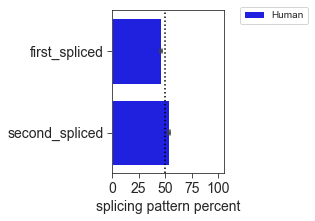

In [73]:
# get splicing order dataframe for K562 cells
K562_1_splicing_order_df = get_both_splicing_order_df(K562_1_intron_pairs_df)
K562_2_splicing_order_df = get_both_splicing_order_df(K562_2_intron_pairs_df)
K562_3_splicing_order_df = get_both_splicing_order_df(K562_3_intron_pairs_df)
K562_4_splicing_order_df = get_both_splicing_order_df(K562_4_intron_pairs_df)
K562_5_splicing_order_df = get_both_splicing_order_df(K562_5_intron_pairs_df)

K562_splicing_order_df = pd.concat([K562_1_splicing_order_df,K562_2_splicing_order_df,K562_3_splicing_order_df,K562_4_splicing_order_df,K562_5_splicing_order_df]).reset_index(drop=True)
K562_splicing_order_df['name'] = 'Human'

fig, ax = plt.subplots(figsize=(2,3))

sns.barplot(x="splicing_status", y="order", hue="name", data=K562_splicing_order_df, palette=['blue','red'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlabel("splicing pattern percent", fontsize=14)
plt.ylabel("", fontsize=14)

plt.xticks([0,25,50,75,100], fontsize=12)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.xlim(0,105)
plt.axvline(x=50, color='black', linestyle=":")

plt.legend(bbox_to_anchor=(1.1, 1.05))

plt.savefig('/path/to/K562_order_of_splicing_horizontal_plot.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

## Splicing coordination across multiple introns

In [74]:
### FUNCTIONS USED TO PLOT SPLICING PATTERNS ACROSS MULTIPLE CONSECUTIVE INTRONS
def get_all_multi_introns(read_junctions, intron_min):

    multi_introns = []

    for read in read_junctions.keys():

        # make a set for all intron pairs within a read
        # this will avoid duplicate pairs being called due to alternative splicing
        uniq_splice_pattern = set()

        # loop through all genes that has introns that a read maps to
        for gene in read_junctions[read].keys():

            # only go through genes that have 2 or more introns
            if ((len(read_junctions[read][gene]) >= intron_min) & (len(read_junctions[read][gene]) <= 10)):

                # characterize the number of spliced and unspliced introns in the read
                splice_status = [row[6] for row in read_junctions[read][gene]]
                splice_status_join = '_'.join(splice_status)
                status_count = Counter(splice_status)

                # only process the file if intron pattern hasn't been seen previously
                # for a gene that this read aligns to
                if (splice_status_join not in uniq_splice_pattern):
                    uniq_splice_pattern.add(splice_status_join)

                    spliced_count = status_count['YES']
                    unspliced_count = status_count['NO']

                    temp = [] 

                    # build a dataframe of introns in the gene that map to this read
                    # and are capable of being sequenced if the read has no splicing
                    read_introns_df = pd.DataFrame(read_junctions[read][gene])
                    read_introns_df.columns = ['chrom','start','end','intron_count','strand','read_overlap','splice_status']
                    read_introns_df = read_introns_df[read_introns_df['read_overlap'] > 0].sort_values('intron_count').reset_index(drop=True)
                    
                    dif = (np.max(read_introns_df['intron_count'])-np.min(read_introns_df['intron_count'])+1)
                    if (len(read_introns_df)==dif):

                        for i in range(len(read_introns_df)):
                            intron_count = read_introns_df.iloc[i]['intron_count']
                            intron_chrom = str(read_introns_df.iloc[i]['chrom'])
                            intron_start = str(read_introns_df.iloc[i]['start'])
                            intron_end = str(read_introns_df.iloc[i]['end'])
                            intron_strand = read_introns_df.iloc[i]['strand']
                            intron_splice = read_introns_df.iloc[i]['splice_status']
                            intron_coord = intron_chrom+'_'+intron_start+'_'+intron_end

                            temp.append(intron_splice)


                        if (intron_strand=='+'):

                            final = []
                            final.append(read)
                            final.append(gene)
                            final.append(intron_strand)

                            for i in temp:
                                final.append(i)

                            for i in range(10-len(temp)):
                                final.append('_')

                            if ((final.count('_')<=7)):
                                multi_introns.append(final)


                        if (intron_strand=='-'):

                            final = []
                            final.append(read)
                            final.append(gene)
                            final.append(intron_strand)

                            for i in reversed(temp):
                                final.append(i)

                            for i in range(10-len(temp)):
                                final.append('_') 

                            if ((final.count('_')<=7)):
                                multi_introns.append(final)
                                

    multi_introns_df = pd.DataFrame(multi_introns)
    multi_introns_df.columns = ['read','gene','strand','int1','int2','int3','int4','int5','int6','int7','int8','int9','int10']
    multi_introns_df = multi_introns_df.sort_values(by=['read']).reset_index(drop=True)

    return multi_introns_df



def get_splicing_pattern_counts(multi_introns_df, total):
    
    gene_list = []
    splice_status_list = []
    read_info = multi_introns_df[['read','gene','strand']]
    multi_introns_df = multi_introns_df.drop(['read','gene','strand'], 1)

    for i in range(0, len(multi_introns_df)):

        itrons_per_read = sum(multi_introns_df.iloc[i]!='_')
        gene = read_info['gene'][i]

        for j in range(0, itrons_per_read-(total-1)):

            splice_status = multi_introns_df.iloc[i][j:j+total]
            splice_status_str = splice_status.str.cat(sep='_')

            gene_list.append([splice_status_str,gene]) # add gene name to count total genes later 
            splice_status_list.append(splice_status_str)

    pattern_gene_df = pd.DataFrame(gene_list)
    pattern_gene_df.columns = ['pattern', 'gene']

    splice_status_counts = Counter(splice_status_list)
    splicing_patterns_df = pd.DataFrame.from_dict(splice_status_counts, orient='index').reset_index()
    splicing_patterns_df.columns = ['pattern','counts']

    return splicing_patterns_df, pattern_gene_df



def get_intron_splicing_percent(splicing_patterns, int_total):

    introns_1yes = splicing_patterns[splicing_patterns['pattern'].str.split('_').apply(lambda x: x.count('YES')) == 1].reset_index(drop=True)
    introns_1yes['percent'] = introns_1yes['counts'].astype(float)/float(np.sum(introns_1yes['counts']))*100

    introns_2yes = splicing_patterns[splicing_patterns['pattern'].str.split('_').apply(lambda x: x.count('YES')) == 2].reset_index(drop=True)
    introns_2yes['percent'] = introns_2yes['counts'].astype(float)/float(np.sum(introns_2yes['counts']))*100

    if (int_total==3):
        return introns_1yes, introns_2yes
    
    if (int_total==4):
        introns_3yes = splicing_patterns[splicing_patterns['pattern'].str.split('_').apply(lambda x: x.count('YES')) == 3].reset_index(drop=True)
        introns_3yes['percent'] = introns_3yes['counts'].astype(float)/float(np.sum(introns_3yes['counts']))*100

        return introns_1yes, introns_2yes, introns_3yes



In [75]:
# get multi intron df for K562
K562_1_multi_introns_df = get_all_multi_introns(K562_1_splice_dictionary, 3)
K562_2_multi_introns_df = get_all_multi_introns(K562_2_splice_dictionary, 3)
K562_3_multi_introns_df = get_all_multi_introns(K562_3_splice_dictionary, 3)
K562_4_multi_introns_df = get_all_multi_introns(K562_4_splice_dictionary, 3)
K562_5a_multi_introns_df = get_all_multi_introns(K562_5a_splice_dictionary, 3)
K562_5b_multi_introns_df = get_all_multi_introns(K562_5b_splice_dictionary, 3)

In [76]:
#K562
K562_5_multi_introns_df = pd.concat([K562_5a_multi_introns_df, K562_5b_multi_introns_df]).reset_index(drop=True)
K562_1_3introns_splicing_patterns, K562_1_pattern_gene_df = get_splicing_pattern_counts(K562_1_multi_introns_df, 3)
K562_2_3introns_splicing_patterns, K562_2_pattern_gene_df = get_splicing_pattern_counts(K562_2_multi_introns_df, 3)
K562_3_3introns_splicing_patterns, K562_3_pattern_gene_df = get_splicing_pattern_counts(K562_3_multi_introns_df, 3)
K562_4_3introns_splicing_patterns, K562_4_pattern_gene_df = get_splicing_pattern_counts(K562_4_multi_introns_df, 3)
K562_5_3introns_splicing_patterns, K562_5_pattern_gene_df = get_splicing_pattern_counts(K562_5_multi_introns_df, 3)

K562_1_3introns_splicing_patterns['rep'] = 'K562_1'
K562_2_3introns_splicing_patterns['rep'] = 'K562_2'
K562_3_3introns_splicing_patterns['rep'] = 'K562_3'
K562_4_3introns_splicing_patterns['rep'] = 'K562_4'
K562_5_3introns_splicing_patterns['rep'] = 'K562_5'

K562_3introns_splicing_patterns = pd.concat([K562_1_3introns_splicing_patterns, K562_2_3introns_splicing_patterns, K562_3_3introns_splicing_patterns, K562_4_3introns_splicing_patterns, K562_5_3introns_splicing_patterns]).reset_index(drop=True)


In [87]:
K562_1_introns_1yes, K562_1_introns_2yes = get_intron_splicing_percent(K562_1_3introns_splicing_patterns, 3)
K562_2_introns_1yes, K562_2_introns_2yes = get_intron_splicing_percent(K562_2_3introns_splicing_patterns, 3)
K562_3_introns_1yes, K562_3_introns_2yes = get_intron_splicing_percent(K562_3_3introns_splicing_patterns, 3)
K562_4_introns_1yes, K562_4_introns_2yes = get_intron_splicing_percent(K562_4_3introns_splicing_patterns, 3)
K562_5_introns_1yes, K562_5_introns_2yes = get_intron_splicing_percent(K562_5_3introns_splicing_patterns, 3)

K562_introns_1yes = pd.concat([K562_1_introns_1yes, K562_2_introns_1yes, K562_3_introns_1yes, K562_4_introns_1yes, K562_5_introns_1yes])
K562_introns_2yes = pd.concat([K562_1_introns_2yes, K562_2_introns_2yes, K562_3_introns_2yes, K562_4_introns_2yes, K562_5_introns_2yes])


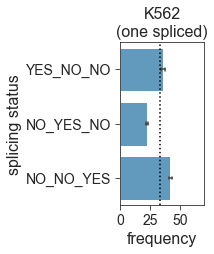

In [88]:
fig, ax = plt.subplots(figsize=(1.5,3))

fill_colors = [sns.color_palette("Blues")[3]]
sns.barplot(x="percent", y="pattern", data=K562_introns_1yes, palette=fill_colors,
           order=['YES_NO_NO','NO_YES_NO','NO_NO_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

#plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=33.3, color='black', linestyle=":")

plt.title("K562\n(one spliced)", fontsize=16)

plt.savefig('/path/to/K562_splicing_order_3int_oneSpliced.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()


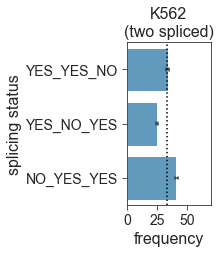

In [89]:
fig, ax = plt.subplots(figsize=(1.5,3))

fill_colors = [sns.color_palette("Blues")[3]]
sns.barplot(x="percent", y="pattern", data=K562_introns_2yes, palette=fill_colors,
           order=['YES_YES_NO','YES_NO_YES','NO_YES_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

#plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=33.3, color='black', linestyle=":")

plt.title("K562\n(two spliced)", fontsize=16)

plt.savefig('/path/to/K562_splicing_order_3int_twoSpliced.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [81]:
K562_1_4introns_splicing_patterns, K562_1_pattern_gene_df = get_splicing_pattern_counts(K562_1_multi_introns_df, 4)
K562_2_4introns_splicing_patterns, K562_2_pattern_gene_df = get_splicing_pattern_counts(K562_2_multi_introns_df, 4)
K562_3_4introns_splicing_patterns, K562_3_pattern_gene_df = get_splicing_pattern_counts(K562_3_multi_introns_df, 4)
K562_4_4introns_splicing_patterns, K562_4_pattern_gene_df = get_splicing_pattern_counts(K562_4_multi_introns_df, 4)
K562_5_4introns_splicing_patterns, K562_5_pattern_gene_df = get_splicing_pattern_counts(K562_5_multi_introns_df, 4)

K562_1_4introns_splicing_patterns['rep'] = 'K562_1'
K562_2_4introns_splicing_patterns['rep'] = 'K562_2'
K562_3_4introns_splicing_patterns['rep'] = 'K562_3'
K562_4_4introns_splicing_patterns['rep'] = 'K562_4'
K562_5_4introns_splicing_patterns['rep'] = 'K562_5'

K562_4introns_splicing_patterns = pd.concat([K562_1_4introns_splicing_patterns, K562_2_4introns_splicing_patterns, K562_3_4introns_splicing_patterns, K562_4_4introns_splicing_patterns, K562_5_4introns_splicing_patterns])


In [90]:
K562_1_introns_1yes, K562_1_introns_2yes, K562_1_introns_3yes = get_intron_splicing_percent(K562_1_4introns_splicing_patterns, 4)
K562_2_introns_1yes, K562_2_introns_2yes, K562_2_introns_3yes = get_intron_splicing_percent(K562_2_4introns_splicing_patterns, 4)
K562_3_introns_1yes, K562_3_introns_2yes, K562_3_introns_3yes = get_intron_splicing_percent(K562_3_4introns_splicing_patterns, 4)
K562_4_introns_1yes, K562_4_introns_2yes, K562_4_introns_3yes = get_intron_splicing_percent(K562_4_4introns_splicing_patterns, 4)
K562_5_introns_1yes, K562_5_introns_2yes, K562_5_introns_3yes = get_intron_splicing_percent(K562_5_4introns_splicing_patterns, 4)

K562_introns_1yes = pd.concat([K562_1_introns_1yes, K562_2_introns_1yes, K562_3_introns_1yes, K562_4_introns_1yes, K562_5_introns_1yes])
K562_introns_2yes = pd.concat([K562_1_introns_2yes, K562_2_introns_2yes, K562_3_introns_2yes, K562_4_introns_2yes, K562_5_introns_2yes])
K562_introns_3yes = pd.concat([K562_1_introns_3yes, K562_2_introns_3yes, K562_3_introns_3yes, K562_4_introns_3yes, K562_5_introns_3yes])


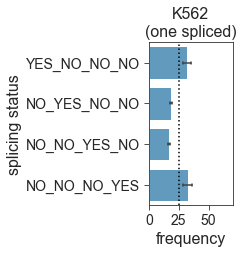

In [91]:
fig, ax = plt.subplots(figsize=(1.5,3))

fill_colors = [sns.color_palette("Blues")[3]]
sns.barplot(x="percent", y="pattern", data=K562_introns_1yes, palette=fill_colors,
           order=['YES_NO_NO_NO','NO_YES_NO_NO','NO_NO_YES_NO','NO_NO_NO_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

#plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=25, color='black', linestyle=":")

plt.title("K562\n(one spliced)", fontsize=16)

plt.savefig('/path/to/K562_splicing_order_4int_oneSpliced.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()


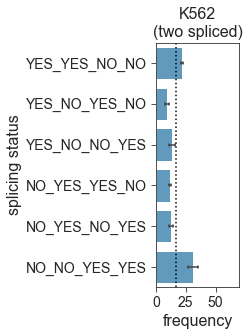

In [92]:
fig, ax = plt.subplots(figsize=(1.5,4.5))

fill_colors = [sns.color_palette("Blues")[3]]
sns.barplot(x="percent", y="pattern", data=K562_introns_2yes, palette=fill_colors,
           order=['YES_YES_NO_NO','YES_NO_YES_NO','YES_NO_NO_YES','NO_YES_YES_NO','NO_YES_NO_YES','NO_NO_YES_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

#plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=16.67, color='black', linestyle=":")

plt.title("K562\n(two spliced)", fontsize=16)

plt.savefig('/path/to/K562_splicing_order_4int_twoSpliced.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()


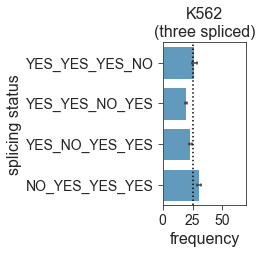

In [94]:
fig, ax = plt.subplots(figsize=(1.5,3))

fill_colors = [sns.color_palette("Blues")[3]]
sns.barplot(x="percent", y="pattern", data=K562_introns_3yes, palette=fill_colors,
           order=['YES_YES_YES_NO','YES_YES_NO_YES','YES_NO_YES_YES','NO_YES_YES_YES'], ci=68, capsize=0.05, errwidth=1.5)

plt.xlim(0,70)

plt.xticks([0,25,50], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

#plt.legend(bbox_to_anchor=(1.1, 1.0), fontsize=14)
plt.ylabel("splicing status", fontsize=16)
plt.xlabel("frequency", fontsize=16)

plt.axvline(x=25, color='black', linestyle=":")

plt.title("K562\n(three spliced)", fontsize=16)

plt.savefig('/path/to/K562_splicing_order_4int_threeSpliced.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()
